# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import accuracy_score,  precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer, LabelEncoder, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import time



In [62]:
#df = pd.read_csv('/Users/luzejames/Documents/Python/M17/module17_starter/data/bank-additional-full.csv', sep = ';')
df = pd.read_csv('/Users/ljames/Documents/Python/M17/data/bank-additional-full.csv', sep = ';')

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [63]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [64]:
# I want to see the records that have 'unknown'  in all these four columns. It's very likely the records are just garbage 
df[
    (df['job'] == 'unknown') &
    (df['default'] == 'unknown') &
    (df['housing'] == 'unknown') &
    (df['loan'] == 'unknown')
]		

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29,55,unknown,married,university.degree,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1915,44,unknown,single,basic.9y,unknown,unknown,unknown,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2723,45,unknown,married,unknown,unknown,unknown,unknown,telephone,may,wed,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,no
21556,44,unknown,married,unknown,unknown,unknown,unknown,cellular,aug,tue,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no


In [65]:
# Drop the rows that have 'unknown' in all these columns
df = df[
    ~(
        (df['job'] == 'unknown') &
        (df['default'] == 'unknown') &
        (df['housing'] == 'unknown') &
        (df['loan'] == 'unknown')
    )
]

In [66]:
df['age'].value_counts()

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

In [67]:
df['job'].value_counts()
# I will leave the 'unknown' in the job column to stand as a category

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            326
Name: count, dtype: int64

In [68]:
df['marital'].value_counts()

marital
married     24925
single      11567
divorced     4612
unknown        80
Name: count, dtype: int64

In [69]:
df[(df['marital'] == 'unknown')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
40,58,management,unknown,university.degree,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
390,59,retired,unknown,university.degree,unknown,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
413,57,retired,unknown,basic.4y,no,no,no,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1493,33,services,unknown,high.school,no,yes,yes,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1608,32,unknown,unknown,university.degree,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38550,31,entrepreneur,unknown,university.degree,no,no,no,cellular,oct,thu,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.722,5017.5,yes
38579,31,entrepreneur,unknown,university.degree,no,yes,no,telephone,oct,thu,...,4,999,1,failure,-3.4,92.431,-26.9,0.722,5017.5,no
39322,30,technician,unknown,university.degree,no,no,no,cellular,mar,mon,...,2,11,2,success,-1.8,93.369,-34.8,0.639,5008.7,yes
39323,30,technician,unknown,university.degree,no,no,no,cellular,mar,mon,...,2,6,2,success,-1.8,93.369,-34.8,0.639,5008.7,yes


In [70]:
# Impute marital = 'unknown' with the most repeated value 
df['marital'] = df['marital'].replace('unknown', 'married')

In [71]:
df['education'].value_counts()

education
university.degree      12167
high.school             9515
basic.9y                6044
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1729
illiterate                18
Name: count, dtype: int64

In [72]:
# Impute education when 'unknown' with the most repeated value within the job. If empty, then use the most repeated one which is 'university.degree'
df['education'] = df.groupby('job')['education'].transform(
    lambda x: x.replace('unknown', x.mode()[0] if not x.mode().empty else 'university.degree')
)

In [73]:
df[(df['education'] == 'unknown') & (df['job'] == 'unknown')  & (df['default'] == 'unknown')]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
73,57,unknown,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
91,57,unknown,married,unknown,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
299,38,unknown,married,unknown,unknown,no,no,telephone,may,mon,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
343,57,unknown,married,unknown,unknown,yes,no,telephone,may,mon,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
388,28,unknown,single,unknown,unknown,yes,yes,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36161,66,unknown,divorced,unknown,unknown,yes,no,cellular,may,wed,...,2,999,1,failure,-1.8,92.893,-46.2,1.270,5099.1,no
38697,81,unknown,divorced,unknown,unknown,yes,no,cellular,nov,mon,...,1,999,1,failure,-3.4,92.649,-30.1,0.715,5017.5,yes
38700,81,unknown,divorced,unknown,unknown,yes,no,cellular,nov,mon,...,1,999,1,failure,-3.4,92.649,-30.1,0.715,5017.5,yes
39108,46,unknown,single,unknown,unknown,yes,no,cellular,dec,mon,...,1,6,1,success,-3.0,92.713,-33.0,0.706,5023.5,no


In [74]:
df = df[~((df['education'] == 'unknown') &(df['job'] == 'unknown') & (df['default'] == 'unknown'))]

In [75]:
# Replace any remaining unknowns with the most  frequent value which is 'university degree'
df['education'] = df['education'].replace('unknown', 'university.degree')

In [76]:
df['default'].value_counts()
# I am not imputing 'unknown' in this column eiether since there are only 3 'yes' and too many 'unknown'. I will leave it as an additional category

default
no         32588
unknown     8521
yes            3
Name: count, dtype: int64

In [77]:
df['housing'].value_counts()

housing
yes        21530
no         18596
unknown      986
Name: count, dtype: int64

In [78]:
# Review the records with 'unknown' in housing, default and loan columns to determine what I want to do with the records 
df[(df['housing'] == 'unknown') &
(df['default'] == 'unknown') &
(df['loan'] == 'unknown') 
]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
81,51,blue-collar,married,basic.4y,unknown,unknown,unknown,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
385,59,management,married,basic.4y,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
401,48,services,married,high.school,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
470,42,technician,single,professional.course,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
494,32,admin.,single,university.degree,unknown,unknown,unknown,telephone,may,tue,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34618,33,blue-collar,married,basic.9y,unknown,unknown,unknown,cellular,may,thu,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.266,5099.1,no
34826,59,management,married,basic.4y,unknown,unknown,unknown,cellular,may,thu,...,4,999,1,failure,-1.8,92.893,-46.2,1.266,5099.1,no
34970,42,self-employed,married,professional.course,unknown,unknown,unknown,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
37661,71,retired,married,basic.4y,unknown,unknown,unknown,cellular,aug,tue,...,1,999,0,nonexistent,-2.9,92.201,-31.4,0.859,5076.2,yes


In [79]:
# Drop the records with 'unknown' in housing, default and loan columns
df = df[~((df['housing'] == 'unknown') & (df['loan'] == 'unknown') &(df['default'] == 'unknown'))]

In [80]:
df['loan'].value_counts()

loan
no         33883
yes         6243
unknown      763
Name: count, dtype: int64

In [81]:
# Imputing 'unknown' with the most repeated value = 'no'
df['loan'] = df['loan'].replace('unknown', 'no')


In [82]:
# This column looks ok
df['contact'].value_counts()

contact
cellular     26022
telephone    14867
Name: count, dtype: int64

In [83]:
# This column looks ok
df['month'].value_counts()

month
may    13639
jul     7125
aug     6136
jun     5260
nov     4091
apr     2626
oct      717
sep      569
mar      545
dec      181
Name: count, dtype: int64

In [84]:
# This column looks ok
df['day_of_week'].value_counts()

day_of_week
thu    8577
mon    8451
wed    8071
tue    8029
fri    7761
Name: count, dtype: int64

In [85]:
df['campaign'].value_counts()

campaign
1     17516
2     10485
3      5307
4      2627
5      1593
6       975
7       626
8       396
9       278
10      224
11      176
12      123
13       91
14       69
17       58
16       50
15       50
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
28        8
26        8
25        8
31        7
30        7
35        5
32        4
33        4
34        3
42        2
40        2
43        2
39        1
41        1
37        1
Name: count, dtype: int64

In [86]:
df['pdays'].value_counts()		

pdays
999    39377
3        439
6        409
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [87]:
# Since 999 might skew the results and it contains a large list of unique values, I wm going to create two additional features and will distribute 
# in buckets.
# Create pdays_contacted = Indicates whether the contact had been contacted
# Create pdays_bucket =  Number of days since last contact and add 'Never contacted' as a category

df['pdays_contacted'] = df['pdays'].apply(lambda x: 0 if x == 999 else 1)
df['pdays_clean'] = df['pdays'].replace(999, np.nan)

# Define the buckets
bins = [-1, 0, 5, 10, 15, 20, np.inf]  
labels = ['0 days', '1-5 days', '6-10 days', '11-15 days', '16-20 days', '21+ days']

df['pdays_bucket'] = pd.cut(df['pdays_clean'], bins=bins, labels=labels)

df['pdays_bucket'] = df['pdays_bucket'].cat.add_categories('Never contacted')
df['pdays_bucket'] = df['pdays_bucket'].fillna('Never contacted')
df['pdays_clean'].drop


<bound method Series.drop of 0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
41183   NaN
41184   NaN
41185   NaN
41186   NaN
41187   NaN
Name: pdays_clean, Length: 40889, dtype: float64>

In [88]:
df['pdays_bucket'].value_counts()						

pdays_bucket
Never contacted    39377
1-5 days             690
6-10 days            603
11-15 days           166
16-20 days            30
0 days                15
21+ days               8
Name: count, dtype: int64

In [89]:
# Drop pdays and pdays_clean columns. No longer necessary
df.drop(columns=['pdays'], inplace=True)
df.drop(columns=['pdays_clean'], inplace=True)

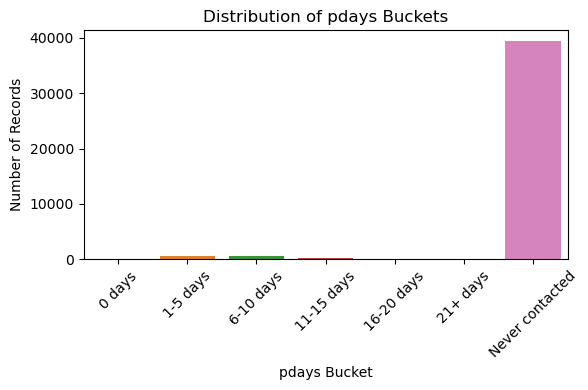

In [90]:
# Graph the buckets
# Count the number of records per bucket
bucket_counts = df['pdays_bucket'].value_counts().sort_index()

# Plot the buckets
plt.figure(figsize=(6,4))

sns.barplot(x=bucket_counts.index, y=bucket_counts.values, hue=bucket_counts.index, legend=False)

plt.title('Distribution of pdays Buckets')
plt.xlabel('pdays Bucket')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [91]:
df['previous'].value_counts()						

previous
0    35282
1     4545
2      753
3      215
4       70
5       18
6        5
7        1
Name: count, dtype: int64

In [92]:
df['emp.var.rate'].value_counts()

emp.var.rate
 1.4    16086
-1.8     9156
 1.1     7654
-0.1     3675
-2.9     1662
-3.4     1069
-1.7      773
-1.1      633
-3.0      171
-0.2       10
Name: count, dtype: int64

In [93]:
df['cons.price.idx'].value_counts()

cons.price.idx
93.994    7654
93.918    6636
92.893    5773
93.444    5134
94.465    4316
93.200    3608
93.075    2452
92.201     769
92.963     715
92.431     447
92.649     355
94.215     311
94.199     302
92.843     281
92.379     267
93.369     264
94.027     233
94.055     229
93.876     212
94.601     203
92.469     178
93.749     174
92.713     171
94.767     128
93.798      67
92.756      10
Name: count, dtype: int64

In [94]:
df['cons.conf.idx'].value_counts()

cons.conf.idx
-36.4    7654
-42.7    6636
-46.2    5773
-36.1    5134
-41.8    4316
-42.0    3608
-47.1    2452
-31.4     769
-40.8     715
-26.9     447
-30.1     355
-40.3     311
-37.5     302
-50.0     281
-29.8     267
-34.8     264
-38.3     233
-39.8     229
-40.0     212
-49.5     203
-33.6     178
-34.6     174
-33.0     171
-50.8     128
-40.4      67
-45.9      10
Name: count, dtype: int64

In [95]:
df['euribor3m'].value_counts()

euribor3m
4.857    2827
4.962    2582
4.963    2470
4.961    1886
4.856    1189
         ... 
3.853       1
3.901       1
0.969       1
0.956       1
3.669       1
Name: count, Length: 316, dtype: int64

In [96]:
df['nr.employed'].value_counts()

nr.employed
5228.1    16086
5099.1     8506
5191.0     7654
5195.8     3675
5076.2     1662
5017.5     1069
4991.6      773
5008.7      650
4963.6      633
5023.5      171
5176.3       10
Name: count, dtype: int64

In [97]:
df['y'].value_counts()

y
no     36265
yes     4624
Name: count, dtype: int64

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40889 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              40889 non-null  int64   
 1   job              40889 non-null  object  
 2   marital          40889 non-null  object  
 3   education        40889 non-null  object  
 4   default          40889 non-null  object  
 5   housing          40889 non-null  object  
 6   loan             40889 non-null  object  
 7   contact          40889 non-null  object  
 8   month            40889 non-null  object  
 9   day_of_week      40889 non-null  object  
 10  duration         40889 non-null  int64   
 11  campaign         40889 non-null  int64   
 12  previous         40889 non-null  int64   
 13  poutcome         40889 non-null  object  
 14  emp.var.rate     40889 non-null  float64 
 15  cons.price.idx   40889 non-null  float64 
 16  cons.conf.idx    40889 non-null  float64 
 17

In [99]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_contacted,pdays_bucket
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,Never contacted
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,Never contacted
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,Never contacted
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,Never contacted
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,Never contacted


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

To create different classification models and compare which one works best with the dataset provided.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [100]:
# Preprocessing and feature engineering

# Target variable
df['y'] = df['y'].map({'yes': 1, 'no': 0})
X = df.copy()
y = X.pop('y')

# I can do ordinal encoding for education, and I will call 'unknown' = -1
education_order = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    'unknown': -1
}
# Encoding education
X['education_encoded'] = X['education'].map(education_order)

# Age bucket
X['age_bucket'] = pd.cut(X['age'], bins=[18, 30, 45, 75, 100],labels=["Young", "Adult", "Senior", "Elderly"])

# Assign numbers to the months
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
X['month_num'] = X['month'].map(month_map)

# Create 'has_credit' when housing is yes and loan is yes
X['has_credit'] = ((X['housing'] == 'yes') | (X['loan'] == 'yes')).astype(int)

# Has the person been contacted before?
X['contacted_before'] = (X['pdays_contacted'] > 0).astype(int)


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40889 entries, 0 to 41187
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              40889 non-null  int64   
 1   job              40889 non-null  object  
 2   marital          40889 non-null  object  
 3   education        40889 non-null  object  
 4   default          40889 non-null  object  
 5   housing          40889 non-null  object  
 6   loan             40889 non-null  object  
 7   contact          40889 non-null  object  
 8   month            40889 non-null  object  
 9   day_of_week      40889 non-null  object  
 10  duration         40889 non-null  int64   
 11  campaign         40889 non-null  int64   
 12  previous         40889 non-null  int64   
 13  poutcome         40889 non-null  object  
 14  emp.var.rate     40889 non-null  float64 
 15  cons.price.idx   40889 non-null  float64 
 16  cons.conf.idx    40889 non-null  float64 
 17

In [102]:
# Create a function to preprocess the data and call it with different features
def create_preprocessing_pipeline(
    ordinal_cols,
    numerical_cols,
    categorical_cols,
    onehot_cols,
    binary_cols,
    passthrough_cols
):
    # Ordinal features: constant imputation and scaling
    ordinal_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
        ('scaler', StandardScaler())
    ])

    # Numeric features: mean imputation and scaling
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    # One-hot features: impute missing then encode
    onehot_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Binary yes/no features
    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='no')),
        ('binary', FunctionTransformer(lambda x: (x == 'yes').astype(int)))
    ])

    # Assemble the full ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('ord', ordinal_transformer, ordinal_cols),
        ('num', num_transformer, numerical_cols),
        ('cat', onehot_transformer, categorical_cols),
        ('ohe', onehot_transformer, onehot_cols),
        ('bin', binary_transformer, binary_cols),
        ('passthrough', 'passthrough', passthrough_cols)
    ])

    return preprocessor


In [103]:
# Columns for preprocessing
preprocessor = create_preprocessing_pipeline(
ordinal_cols = ['education_encoded'],
numerical_cols = ['age', 'duration', 'campaign', 'pdays_contacted', 'previous', 'emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed', 
                  'month_num', 'has_credit', 'contacted_before'],
onehot_cols = ['poutcome','pdays_bucket'],
binary_cols = ['default', 'housing', 'loan'],
passthrough_cols = ['has_credit', 'month_num', 'contacted_before'],
categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'age_bucket']
)

In [104]:
print(X.columns.tolist())

['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pdays_contacted', 'pdays_bucket', 'education_encoded', 'age_bucket', 'month_num', 'has_credit', 'contacted_before']


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [106]:
y.value_counts(normalize=True)

y
0    0.886913
1    0.113087
Name: proportion, dtype: float64

In [107]:
# 89% of the contacts did not subscribe, while only 11% did

In [108]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Dummy classifier accuracy:", accuracy_score(y_test, y_pred_dummy))


Dummy classifier accuracy: 0.8868916605527024


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [109]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)


### Problem 9: Score the Model

What is the accuracy of your model?

In [110]:
# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95      7253
           1       0.67      0.45      0.54       925

    accuracy                           0.91      8178
   macro avg       0.80      0.71      0.74      8178
weighted avg       0.90      0.91      0.90      8178



In [111]:
# The model presents a strong performance when predicting class '0'. With the precision, recall and F1 being over 90%.
# In contrast it is struggling to predict the minority class '1'. With the precision score being 0.67 and Recall just at 0.45.


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [112]:
def evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC()
    }

    results = []

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start_time

        y_pred = model.predict(X_test)

        train_acc = model.score(X_train, y_train)
        test_acc = model.score(X_test, y_test)

        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        results.append({
            'Model': name,
            'Train Time (s)': round(train_time, 4),
            'Train Accuracy': round(train_acc, 4),
            'Test Accuracy': round(test_acc, 4),
            'Precision (macro)': round(precision, 4),
            'Recall (macro)': round(recall, 4),
            'F1-score (macro)': round(f1, 4)
        })

    return pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False)


In [113]:
# Pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Transform the data
X_processed = full_pipeline.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)

# Evaluate models
results_df = evaluate_models(X_train, X_test, y_train, y_test)

# Display results
print(results_df)


                 Model  Train Time (s)  Train Accuracy  Test Accuracy  \
0  Logistic Regression          0.4454          0.9124         0.9090   
3                  SVM          8.6544          0.9119         0.9068   
1                  KNN          0.0000          0.9279         0.8973   
2        Decision Tree          0.2543          1.0000         0.8872   

   Precision (macro)  Recall (macro)  F1-score (macro)  
0             0.8009          0.6962            0.7333  
3             0.8098          0.6633            0.7061  
1             0.7539          0.6847            0.7114  
2             0.7249          0.7213            0.7231  


In [114]:
# 1. Logistic Regression: Best Model. It is efficient, accurate and balanced. Best performer with high test accuracy and balanced F1-Score.
#       Precision and recal are reasonable (both classes are performing well). It is fast and reliable.
# 2. SVM: Very Strong, but computationally expensive and lower recall. High accuracy, nearly identical to Logistic Regression, but recall is 
#     the lowest among all models, which means it's missing more of the minority class. It is the slowest model.
# 3. KNN: Quick but less robust. With the highest train accuracy after Decision Tree, but generalizes worse. Fast to train. Balanced precision and recall, but not outstanding.
# 4. Decision Tree: Most overfit. Perfect train accuracy (1.0) but it has the lowest test accuracy, indicating poor generalization. However, F1, precision and 
#    recall are all similar, showing consistency in class prediction.


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

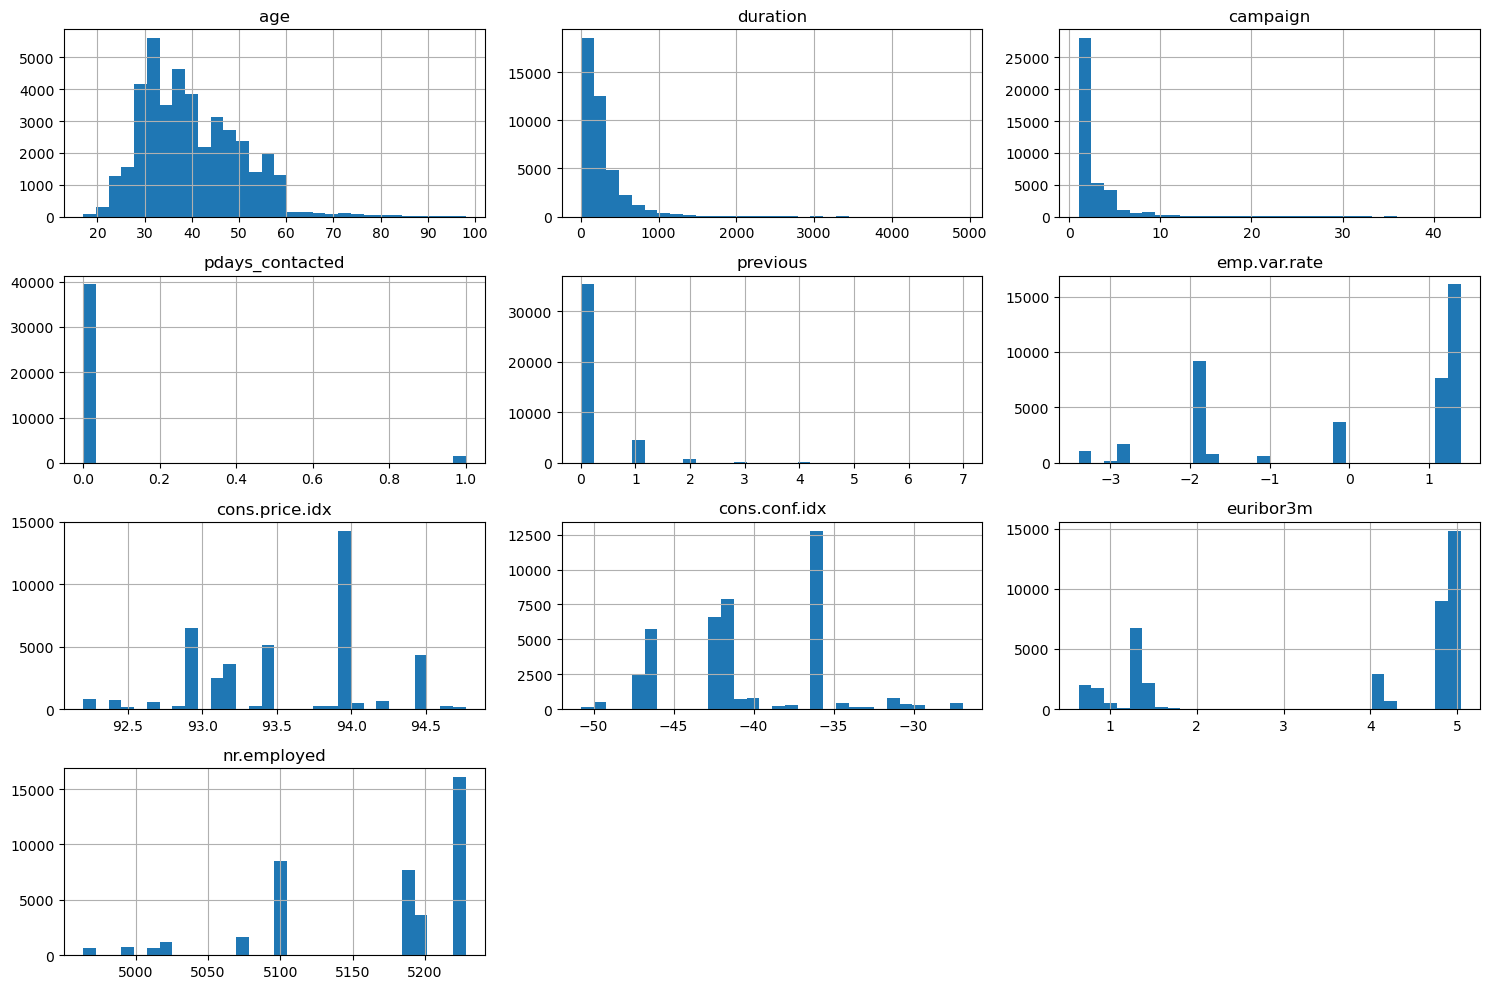

In [115]:
# Plot numeric features
numeric_features = ['age', 'duration', 'campaign', 'pdays_contacted', 'previous',
                    'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
                    'nr.employed']

df[numeric_features].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

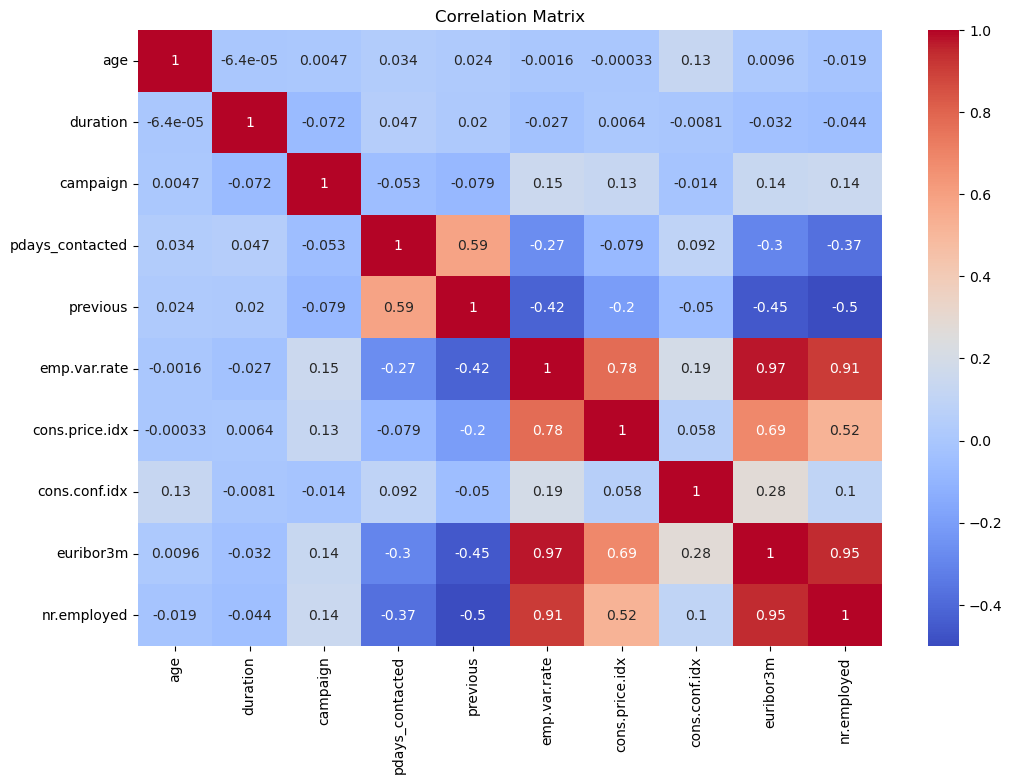

In [116]:
# Plot the correlation matrix to see if I should drop some features
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [117]:
# Removing emp.var.rate', 'nr.employed
df.drop(columns=['emp.var.rate', 'nr.employed'], inplace=True)

In [118]:
# Columns for preprocessing

preprocessor = create_preprocessing_pipeline(
ordinal_cols = ['education_encoded'],
numerical_cols = ['duration', 'campaign', 'pdays_contacted', 'previous','month_num', 'has_credit', 'contacted_before', 'cons.price.idx', 'cons.conf.idx', 'euribor3m'],
onehot_cols = ['poutcome','pdays_bucket'],
binary_cols = ['default', 'housing', 'loan'],
passthrough_cols = ['has_credit', 'month_num', 'contacted_before'],
categorical_cols = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'age_bucket']
)

<Figure size 640x480 with 0 Axes>

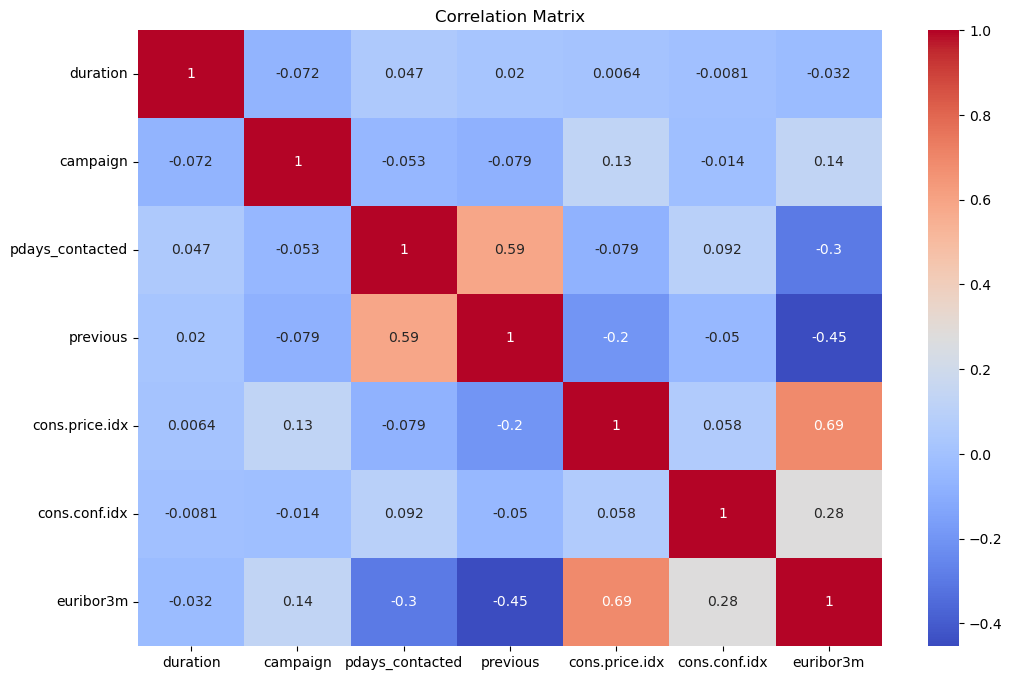

In [120]:
# Plot numerical features that were left
numeric_features_left = ['duration', 'campaign', 'pdays_contacted', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
plt.tight_layout()
plt.show()
plt.figure(figsize=(12, 8))
corr_matrix = df[numeric_features_left].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [122]:
# Define the models and hyperparameters with the new columns
models = {
    'knn': (KNeighborsClassifier(), {'knn__n_neighbors': [3, 5, 7]}),
    'logisticregression': (LogisticRegression(max_iter=1000), {'logisticregression__C': [0.01, 2, 10]}),
    'svc': (SVC(), {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'decisiontreeclassifier': (DecisionTreeClassifier(), {'decisiontreeclassifier__max_depth': [6, 12, 20]})
}


🔍 Tuning and evaluating: knn


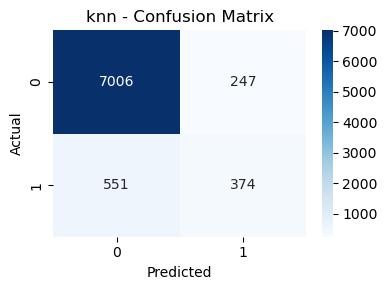


🔍 Tuning and evaluating: logisticregression


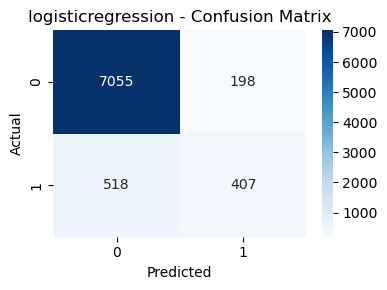


🔍 Tuning and evaluating: svc


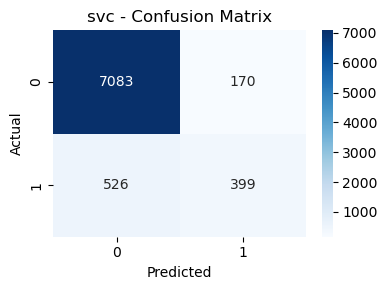


🔍 Tuning and evaluating: decisiontreeclassifier


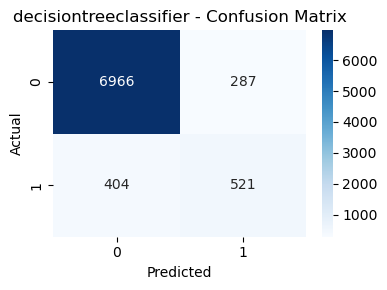

Summary Scores:
                    Model  Train Score  Test Score   Fit Time
0                     knn     0.921922    0.902421   2.086860
1      logisticregression     0.910825    0.912448   0.818823
2                     svc     0.923206    0.914894  63.563271
3  decisiontreeclassifier     0.920210    0.915505   0.678463
Performance Matrix:
                    Model  Accuracy  Precision    Recall  F1-score
0                     knn  0.902421   0.890346  0.902421  0.893829
1      logisticregression  0.912448   0.902319  0.912448  0.904237
2                     svc  0.914894   0.904897  0.914894  0.905773
3  decisiontreeclassifier  0.915505   0.911208  0.915505  0.912991


In [123]:
results_17A = []
performance_matrix = []

for name, (model, params) in models.items():
    print(f"\n🔍 Tuning and evaluating: {name}")
    
    # Create a pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)
    ])
    
    # Grid Search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Fit the model and time it
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    fit_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test)
    
    # Get the Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    
    # Append the summary scores 
    results_17A.append([name, best_model.score(X_train, y_train), acc, fit_time])

    # Append detailed performance matrix
    performance_matrix.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1
    })
    
    # Create a Confusion matrix plot for each model
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

# Convert to DataFrame
results_17A_df = pd.DataFrame(results_17A, columns=['Model', 'Train Score', 'Test Score', 'Fit Time'])
performance_df = pd.DataFrame(performance_matrix)

# Display results
print("Summary Scores:")
print(results_17A_df)

print("Performance Matrix:")
print(performance_df)


##### Questions